In [1]:
import os
import shutil
import glob
import subprocess
import pandas as pd
import geopandas as gpd
import dask
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools

Launch a parallel computing cluster. 

In [2]:
cluster=LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)
num_cores = len(c.ncores()) # identify how many workers we have

At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

In [3]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')

In [4]:
# where the imported lidar data is currently stored
workdir = os.path.abspath('/storage/lidar/swinomish_2012/')
# define data handling directories
processed = os.path.join(workdir,'processed')

# the coordinate reference system we'll be working with
target_epsg = 26910 # utm 10 N

In [5]:
# push our working directories and wrapper classes to the workers on the cluster as well
c.scatter([processed, las, target_epsg, num_cores], broadcast=True);

In [6]:
def fname(path):
    """returns the filename as basename split from extension.
    
    Parameters
    -----------
    path : str, path to file
        filepath from which filename will be sliced
        
    
    Returns
    --------
    filename : str
        name of file, split from extension
    """
    filename = os.path.basename(path).split('.')[0]
    return filename

In [7]:
tiles_to_merge = [fname(tile) for tile in 
                  glob.glob(os.path.join(processed, 'points', '*.laz'))
                 ]

print('Found {:,d} tiles to merge derivative products from.'.format(len(tiles_to_merge)))

Found 56 tiles to merge derivative products from.


# Merge tiled derivative outputs together
Merge all the tiled GeoTiffs and Shapefiles into single overview files.

We'll produce a shapefile showing the layout of the non-buffered tiles as a single shapefile. This is a single process that takes a few seconds to run, so no need to distribute it using `dask`.

In [8]:
@dask.delayed
def tile_boundaries(*args, **kwargs):
    odir = os.path.join(processed, 'vectors')
    
    if os.path.exists(os.path.join(processed, 'vectors', 'tiles.shp')):
        pass
    else:
        proc = las.lasboundary(i=os.path.join(processed, 'points', '*.laz'),
                               use_bb=True, # use bounding box of tiles
                               overview=True,
                               labels=True,
                               cores=num_cores, # use parallel processing
                               oshp=True,
                               o=os.path.join(processed, 'vectors', 'tiles.shp'))
    return

In [9]:
@dask.delayed
def make_footprint(*args, **kwargs):
    if os.path.exists(os.path.join(processed, 'vectors', 'footprint.shp')):
        pass
    else:
        gdf = gpd.read_file(os.path.join(processed, 'vectors', 'tiles.shp'))
        gdf['mil_points'] = gdf['num_points'] / 1000000.
        buffered = gdf.drop(['file_name', 'point_size', 'point_type', 'num_points'], axis=1)
        buffered.geometry = gdf.buffer(0.01) # buffer by 1cm
        
        try:
            union = gpd.GeoDataFrame(geometry=list(buffered.unary_union), crs=buffered.crs)
        except TypeError: # line above will fail if there is only one polygon for the footprint
            union = gpd.GeoDataFrame(geometry=[buffered.unary_union], crs=buffered.crs)
    
        union['footprint_id'] = union.index + 1
        
        buffered = gpd.tools.sjoin(buffered, union, how='left').drop('index_right', axis=1)
        
        aggfuncs={'mil_points':'sum', 
          'version':'first', 
          'min_x':'min',
          'min_y':'min',
          'min_z':'min',
          'max_x':'max',
          'max_y':'max',
          'max_z':'max'}
        
        dissolved = buffered.dissolve(by='footprint_id', aggfunc=aggfuncs)
        
        dissolved.to_file(os.path.join(processed, 'vectors', 'footprint.shp'))
        
        return 'footprint'

In [10]:
def merge_chunks(infiles, outfile):
    """Merges a list of rasters, one chunk at a time.
    
    Parameters
    -----------
    infiles : list
        list containing paths to input files
    outfile : string, path to file
        the output file that will be created by merging all the input files
    """
    if os.path.exists(outfile):
        pass
    else:
        outname = os.path.basename(outfile).split('.')[0]
        os.makedirs(os.path.join(processed, 'rasters','chunks'), exist_ok=True)
        
        # break the list of input files into chunks of 500
        for i in range(0,len(infiles),500):
            chunk_infiles = infiles[i:i+500]
            chunk_outfile = os.path.join(processed, 'rasters', 'chunks', 'chunk{}_{}.tif'.format(i, outname))
            proc = subprocess.run(['rio', 'merge', *chunk_infiles, chunk_outfile, '--co', 'compress=LZW',
                              '--co', 'tiled=true', '--co', 'blockxsize=256', '--co', 'blockysize=256',
                              '--co', 'bigtiff=YES'],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        
        chunked_outfiles = glob.glob(os.path.join(processed, 'rasters', 'chunks', 'chunk*{}*.tif'.format(outname)))
    
        proc = subprocess.run(['rio', 'merge', *chunked_outfiles, outfile, '--co', 'compress=LZW',
                              '--co', 'tiled=true', '--co', 'blockxsize=256', '--co', 'blockysize=256',
                              '--co', 'bigtiff=YES'],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    return

Merge the bare earth tiles into a single GeoTiff.

In [11]:
@dask.delayed
def merge_dem(*args, **kwargs):
    infiles = glob.glob(os.path.join(processed, 'rasters', 'DEM_tiles', '*.tif'))
    outfile = os.path.join(processed, 'rasters', 'dem.tif')
    
    if os.path.exists(outfile):
        pass
    
    elif len(infiles) < 500:
            return subprocess.run(['rio', 'merge', *infiles, outfile, '--co', 'compress=LZW',
                                  '--co', 'tiled=true', '--co', 'blockxsize=256', '--co', 'blockysize=256',
                                  '--co', 'bigtiff=YES'],
                                  stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    else:
        merge_chunks(infiles, outfile)
    
    return

Now merge the hillshade tiles into a single raster formatted as GeoTiff.

In [12]:
@dask.delayed
def merge_hillshade(*args, **kwargs):
    infiles = glob.glob(os.path.join(processed, 'rasters', 'hillshade_tiles', '*.tif'))
    outfile = os.path.join(processed, 'rasters', 'hillshade.tif')

    if os.path.exists(outfile):
        pass
    
    elif len(infiles) < 500:
            return subprocess.run(['rio', 'merge', *infiles, outfile, '--co', 'compress=LZW',
                              '--co', 'tiled=true', '--co', 'blockxsize=256', '--co', 'blockysize=256',
                              '--co', 'bigtiff=YES'],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    else:
        merge_chunks(infiles, outfile)
    return

Merge the trimmed canopy height model tiles into a single raster.

In [13]:
@dask.delayed
def merge_chm(*args, **kwargs):
    infiles = glob.glob(os.path.join(processed, 'rasters', 'chm_tiles', '*.tif'))
    outfile = os.path.join(processed, 'rasters', 'chm.tif')
    
    if os.path.exists(outfile):
        pass
    
    elif len(infiles) < 500:
            proc = subprocess.run(['rio', 'merge', *infiles, outfile, '--co', 'compress=LZW',
                                  '--co', 'tiled=true', '--co', 'blockxsize=256', '--co', 'blockysize=256',
                                  '--co', 'bigtiff=YES'],
                                  stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    else:
        merge_chunks(infiles, outfile)
    
    return

Merge the cleaned tiles of building footprints together into a single shapefile. We'll use `geopandas` to concatenate all the polygons together into a single geodataframe and then write out to a new shapefile.

In [14]:
@dask.delayed
def merge_bldgs(*args, **kwargs):
    
    if os.path.exists(os.path.join(processed,'vectors','buildings.shp')):
        pass
    else:
        building_tiles = glob.glob(os.path.join(processed, 'vectors', 'building_tiles', '*.shp'))
        # create a list of geodataframes containing the tiles of building footprints
        gdflist = [gpd.read_file(tile) for tile in building_tiles]
        # merge them all together
        merged = gpd.GeoDataFrame(pd.concat(gdflist, ignore_index=True))
        # using pandas' concat caused us to lose projection information, so let's add that back in
        merged.crs = gdflist[0].crs
        # and write the merged data to a new shapefile
        merged.to_file(os.path.join(processed,'vectors','buildings.shp'))

    return

In [15]:
# identify the variety of rasters produced by gridmetrics
example_tile = tiles_to_merge[0]
grid_rasters = [os.path.basename(file).split(example_tile)[-1][1:-4] for file in 
                glob.glob(os.path.join(processed, 'rasters', 'gridmetrics_tiles', example_tile + '*'))
               ]
print('{:d} different types of rasters from gridmetrics to process for each tile:\r\n'.format(len(grid_rasters)))
for i, raster in enumerate(grid_rasters):
    print('{}.  {}'.format(i+1, raster))

24 different types of rasters from gridmetrics to process for each tile:

1.  strat0_return-proportion
2.  strat1_return-proportion
3.  strat2_return-proportion
4.  strat3_return-proportion
5.  strat4_return-proportion
6.  strat5_return-proportion
7.  strat0_intensity-median
8.  strat1_intensity-median
9.  strat2_intensity-median
10.  strat3_intensity-median
11.  strat4_intensity-median
12.  strat5_intensity-median
13.  elevation
14.  slope
15.  profile_curvature
16.  plan_curvature
17.  solar_radiation_index
18.  height_max
19.  height_05-percentile
20.  height_25-percentile
21.  height_50-percentile
22.  height_75-percentile
23.  height_95-percentile
24.  cover


In [16]:
@dask.delayed
def merge_gridmetric(metric):
    infiles = glob.glob(os.path.join(processed, 'rasters', 'gridmetrics_tiles', '*{}*.tif'.format(metric)))
    outfile = os.path.join(processed, 'rasters', '{}.tif'.format(metric))
    
    if os.path.exists(outfile):
        pass
    
    elif len(infiles) < 500:
        proc = subprocess.run(['rio', 'merge', *infiles, outfile, '--co', 'compress=LZW',
                              '--co', 'tiled=true', #'--co', 'blockxsize=256', '--co', 'blockysize=256',
                              '--co', 'bigtiff=YES'],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    else:
        merge_chunks(infiles, outfile)
    
#     print(metric)
    return metric

A single state that will depend upon the completion of the merged rasters and vectors.

In [17]:
@dask.delayed
def merge_done(*args, **kwargs):
    return

In [18]:
# building the computation receipe
merge_dsk = {}
merge_dsk['tile_boundaries'] = (tile_boundaries,)
merge_dsk['footprint'] = (make_footprint, 'tile_boundaries')
merge_dsk['merge_bldgs'] = (merge_bldgs,)
merge_dsk['merge_hill'] = (merge_hillshade,)
merge_dsk['merge_dem'] = (merge_dem,)
merge_dsk['merge_chm'] = (merge_chm,)
for raster in grid_rasters:
    merge_dsk['merge_gridmetric-{}'.format(raster)] = (merge_gridmetric, raster)
    
merge_dsk['merge_done']=(merge_done, ['tile_boundaries', 'merge_bldgs', 'footprint'] +
                                     ['merge_hill', 'merge_dem', 'merge_chm'] + 
                                     ['merge_gridmetric-{}'.format(raster) for raster in grid_rasters])

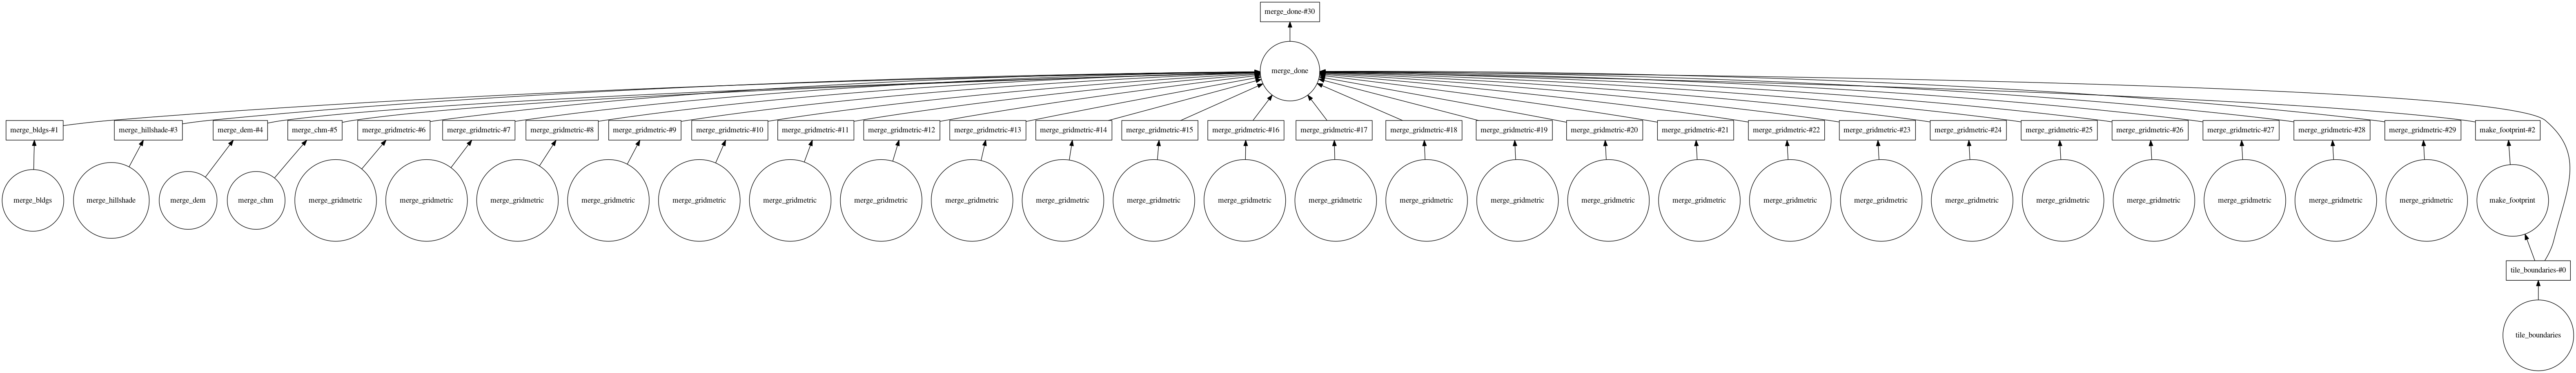

In [19]:
merge_graph = c.get(merge_dsk, 'merge_done') # build the computation graph
merge_graph.visualize()

In [20]:
merge_results = c.compute(merge_graph) # this might take a while...

In [21]:
# merge_results.result()

In [22]:
progress(merge_results)
# progress(gridm_res)

VBox()

In [23]:
# procs = []
# for raster in grid_rasters:
#     procs.append(merge_gridmetric(raster))

In [24]:
# c.cancel(merge_results)

In [25]:
# c.close()
# cluster.close()